In [53]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import re
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Concatenate, Dense, Input,Dropout
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, AdamW

In [39]:
# Specify the folder path where your CSV files are located
folder_path = "/Users/kianathakkar/Documents/dataset/quora-question-pairs/train.csv"

df_train = pd.read_csv(folder_path)

In [40]:
# Specify the folder path where your CSV files are located
folder_path_test = "/Users/kianathakkar/Documents/dataset/quora-question-pairs/test.csv"

df_test = pd.read_csv(folder_path_test)

In [41]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [42]:
# Tokenization and Lemmatization
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kianathakkar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kianathakkar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [43]:
# Preprocessing and Cleaning Text Data
def preprocess_text(text):
    
    # Check if the input is a non-empty string
    if isinstance(text, str) and text.strip():  # Check if it's a non-empty string
        # Lowercase the text
        text = text.lower()

        # Replace certain special characters with their string equivalents
        text = text.replace('%', ' percent')
        text = text.replace('$', ' dollar ')
        text = text.replace('₹', ' rupee ')
        text = text.replace('€', ' euro ')
        text = text.replace('@', ' at ')
        
        # The pattern '[math]' appears around 900 times in the whole dataset.
        text = text.replace('[math]', '')       

        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
         
    return text

In [44]:
# Define a dictionary of common English contractions and their expanded forms
contractions_dict = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "I'd": "I would",
    "I'll": "I will",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it's": "it is",
    "let's": "let us",
    "might've": "might have",
    "mustn't": "must not",
    "shan't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that's": "that is",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "we'd": "we would",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what's": "what is",
    "when's": "when is",
    "where's": "where is",
    "who's": "who is",
    "why's": "why is",
    "won't": "will not",
    "would've": "would have",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have"
}

# Function to expand contractions
def expand_contractions(text, contractions_dict):
    
    if isinstance(text, str):
        words = text.split()
        expanded_words = [contractions_dict.get(word, word) for word in words]
        expanded_text = " ".join(expanded_words)
        return expanded_text
    else:
        return text 
    

In [45]:
# Tokenization and Lemmatization
def tokenize_and_lemmatize(text):
    if isinstance(text, str):
        words = text.split()
        words = [lemmatizer.lemmatize(word) for word in words]
        return ' '.join(words)
    else:
        return text  # Return the input as is if it's not a string

In [46]:

# List of column names to clean
columns_to_clean = ['question1','question2']

# Apply the functions to each column in the DataFrame
for column in columns_to_clean:
    # Apply the special character removal function
    df_train[column] = df_train[column].apply(preprocess_text)
    df_test[column] = df_test[column].apply(preprocess_text)

    # Apply the contraction expansion function
    df_train[column] = df_train[column].apply(expand_contractions, args=(contractions_dict,))
    df_test[column] = df_test[column].apply(expand_contractions, args=(contractions_dict,))   
     
    # Apply the stop word removal function
    df_train[column] = df_train[column].apply(tokenize_and_lemmatize)
    df_test[column] = df_test[column].apply(tokenize_and_lemmatize)

In [47]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math is divided by,0
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0


In [48]:
# Assuming you have preprocessed text in 'question1' and 'question2' columns
question1_texts = df_train['question1'].apply(lambda x: str(x))
question2_texts = df_train['question2'].apply(lambda x: str(x))

# Tokenize the text in both columns
question1_tokens = [word_tokenize(text) for text in question1_texts]
question2_tokens = [word_tokenize(text) for text in question2_texts]

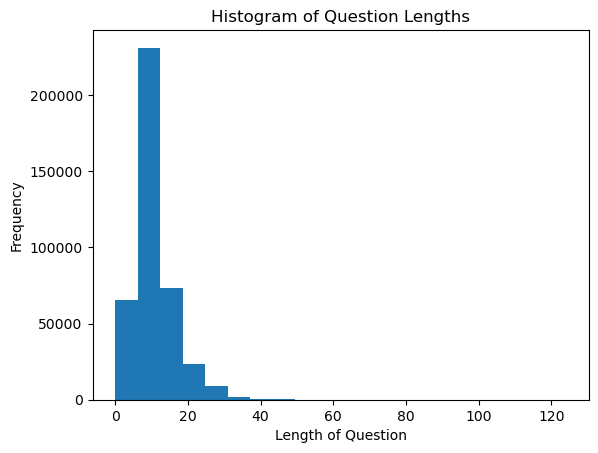

In [49]:
import matplotlib.pyplot as plt

# Create a list to store the lengths of the internal lists
lengths = [len(internal_list) for internal_list in question1_tokens]

# Create a histogram
plt.hist(lengths, bins=20)  # Adjust the number of bins as needed
plt.xlabel('Length of Question')
plt.ylabel('Frequency')
plt.title('Histogram of Question Lengths')

# Show the histogram
plt.show()

In [50]:
# Tokenization and sequence padding
max_seq_length = 40  # Define your maximum sequence length
tokenizer = Tokenizer()
tokenizer.fit_on_texts(question1_tokens + question2_tokens)
question1_sequences = tokenizer.texts_to_sequences(question1_tokens)
question2_sequences = tokenizer.texts_to_sequences(question2_tokens)
question1_sequences = pad_sequences(question1_sequences, maxlen=max_seq_length)
question2_sequences = pad_sequences(question2_sequences, maxlen=max_seq_length)


In [51]:
# Split data into training and testing sets
X = np.column_stack((question1_sequences, question2_sequences))
y = df_train['is_duplicate'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:

# Build the LSTM model
embedding_dim = 100  # Define your desired embedding dimension
lstm_units = 64  # Define the number of LSTM units

input1 = Input(shape=(max_seq_length,))
input2 = Input(shape=(max_seq_length,))

embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim)
lstm_layer = LSTM(lstm_units)

encoded1 = lstm_layer(embedding_layer(input1))
encoded2 = lstm_layer(embedding_layer(input2))

2023-10-05 22:15:46.101556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-05 22:15:46.102249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-05 22:15:46.102944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [54]:
# Concatenate 
merged = Concatenate()([encoded1, encoded2])

# Add dropout layers
dropout_rate = 0.2  
dropout1 = Dropout(dropout_rate)(merged)  

# Add one or more Dense layers
dense_units = 128  # Define the number of units in the dense layers

dense1 = Dense(dense_units, activation='relu', kernel_initializer=HeNormal())(dropout1)   # Add a dense layer after the Concatenate layer
dense2 = Dense(dense_units, activation='relu', kernel_initializer=HeNormal())(dense1)  # Optionally, you can add more dense layers

# Add the final output layer
output = Dense(1, activation='sigmoid')(dense2)

model = Model(inputs=[input1, input2], outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [36]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 40, 100)      9021100     ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 64)           42240       ['embedding_1[0][0]',      

In [55]:

# Train the model
model.fit([X_train[:, :max_seq_length], X_train[:, max_seq_length:]], y_train, batch_size=64, epochs=5, validation_data=([X_test[:, :max_seq_length], X_test[:, max_seq_length:]], y_test))

Epoch 1/5


2023-10-05 22:17:23.877233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-05 22:17:23.879744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-05 22:17:23.880386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5054/5054 [==============================] - ETA: 0s - loss: 0.4768 - accuracy: 0.7692

2023-10-05 22:21:27.765326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-05 22:21:27.765859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-05 22:21:27.766580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5054/5054 [==============================] - 252s 50ms/step - loss: 0.4768 - accuracy: 0.7692 - val_loss: 0.4276 - val_accuracy: 0.8003
Epoch 2/5
5054/5054 [==============================] - 251s 50ms/step - loss: 0.3693 - accuracy: 0.8315 - val_loss: 0.4070 - val_accuracy: 0.8135
Epoch 3/5
5054/5054 [==============================] - 247s 49ms/step - loss: 0.3030 - accuracy: 0.8658 - val_loss: 0.4041 - val_accuracy: 0.8186
Epoch 4/5
5054/5054 [==============================] - 250s 49ms/step - loss: 0.2553 - accuracy: 0.8890 - val_loss: 0.4174 - val_accuracy: 0.8205
Epoch 5/5
5054/5054 [==============================] - 250s 49ms/step - loss: 0.2192 - accuracy: 0.9056 - val_loss: 0.4553 - val_accuracy: 0.8140
